Flowers Dataset (download it for this notebook): http://download.tensorflow.org/example_images/flower_photos.tgz
<br>This code is partially based on the Kwotsin tutorial: https://kwotsin.github.io/tech/2017/01/29/tfrecords.html

For the Flowers dataset, you should be able to see that your data is arranged into the following structure:

flowers\<br>
    &emsp;flower_photos\<br>
        &emsp;&emsp;tulips\<br>
 &emsp;&emsp;&emsp;&emsp;           ....jpg<br>
 &emsp;&emsp;&emsp;&emsp;           ....jpg<br>
 &emsp;&emsp;&emsp;&emsp;          ....jpg<br>
 &emsp;&emsp;       sunflowers\<br>
 &emsp;&emsp;&emsp;&emsp;           ....jpg<br>
 &emsp;&emsp;       roses\<br>
 &emsp;&emsp;&emsp;&emsp;           ....jpg<br>
 &emsp;&emsp;       dandelion\<br>
 &emsp;&emsp;&emsp;&emsp;           ....jpg<br>
 &emsp;&emsp;       daisy\<br>
 &emsp;&emsp;&emsp;&emsp;           ....jpg<br>
            
            


In [12]:
import math
import os
import sys
import tensorflow as tf
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

slim = tf.contrib.slim

#State the labels filename
LABELS_FILENAME = 'labels.txt'
#===================================================  Dataset Utils  ===================================================

def _int64_feature(values):
    if not isinstance(values, (tuple, list)):
        values = [values]
    return tf.train.Feature(int64_list=tf.train.Int64List(value=values))


def _bytes_feature(values):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[values]))


def image_to_tfexample(image_data, image_format, height, width, class_id, compression):
    return tf.train.Example(features=tf.train.Features(feature={
        'height': _int64_feature(height),
        'width': _int64_feature(width),
        'label': _int64_feature(class_id),
        'image_raw': _bytes_feature(image_data),
        'encoded': _bytes_feature(image_format), 
        'compression': _int64_feature(compression),
    }))


def write_label_file(labels_to_class_names, dataset_dir,
                     filename=LABELS_FILENAME):
    """Writes a file with the list of class names.
    
    Args:
        labels_to_class_names: A map of (integer) labels to class names.
        dataset_dir: The directory in which the labels file should be written.
        filename: The filename where the class names are written.
      """
    print('Class filename is {0}'.format(os.path.join(dataset_dir,filename)))
    labels_filename = os.path.join(dataset_dir, filename)
    
    
    with tf.gfile.Open(labels_filename, 'w') as f:
        for label in labels_to_class_names:
            class_name = labels_to_class_names[label]
            f.write('%d:%s\n' % (label, class_name))


def has_labels(dataset_dir, filename=LABELS_FILENAME):
    """Specifies whether or not the dataset directory contains a label map file.
    Args:
        dataset_dir: The directory in which the labels file is found.
        filename: The filename where the class names are written.

      Returns:
        'True' if the labels file exists and `False` otherwise.
      """
    return tf.gfile.Exists(os.path.join(dataset_dir, filename))


def read_label_file(dataset_dir, filename=LABELS_FILENAME):
    """Reads the labels file and returns a mapping from ID to class name.
    
    Args:
        dataset_dir: The directory in which the labels file is found.
        filename: The filename where the class names are written.
    Returns:
        A map from a label (integer) to class name.
    """
    labels_filename = os.path.join(dataset_dir, filename)
    with tf.gfile.Open(labels_filename, 'r') as f:
        lines = f.read().decode()
    lines = lines.split('\n')
    lines = filter(None, lines)
    
    labels_to_class_names = {}
    for line in lines:
        index = line.index(':')
        labels_to_class_names[int(line[:index])] = line[index+1:]
    return labels_to_class_names

#=======================================  Conversion Utils  ===================================================

#Create an image reader object for easy reading of the images
class ImageReader(object):
    """Helper class that provides TensorFlow image coding utilities."""
    
    def __init__(self):
        # Initializes function that decodes RGB JPEG data.
        self._decode_jpeg_data = tf.placeholder(dtype=tf.string)
        self._decode_jpeg = tf.image.decode_jpeg(self._decode_jpeg_data, channels=3)
        #self._decode_png_data = tf.placeholder(dtype=tf.string)
        #self._decode_png = tf.image.decode_png(self._decode_png_data, channels=3)
        
    
    def read_image_dims(self, sess, image_data):
        image = self.decode_jpeg(sess, image_data)
        #image = self.decode_png(sess, image_data)
        return image.shape[0], image.shape[1]

    def decode_jpeg(self, sess, image_data): #jpeg
        image = sess.run(self._decode_jpeg, feed_dict={self._decode_jpeg_data: image_data})
        assert len(image.shape) == 3
        assert image.shape[2] == 3
        return image
    
    def decode_png(self, sess, image_data): #png
        image = sess.run(self._decode_png, feed_dict={self._decode_png_data: image_data})
        assert len(image.shape) == 3
        assert image.shape[2] == 3
        return image

def _get_filenames_and_classes(dataset_dir):
    """Returns a list of filenames and inferred class names.
    Args:
        dataset_dir: A directory containing a set of subdirectories representing
          class names. Each subdirectory should contain PNG or JPG encoded images.
    Returns:
        A list of image file paths, relative to `dataset_dir` and the list of
        subdirectories, representing class names.
      """
    # print 'DATASET DIR:', dataset_dir
    # print 'subdir:', [name for name in os.listdir(dataset_dir)]
    # dataset_main_folder_list = []
    # for name in os.listdir(dataset_dir):
    # 	if os.path.isdir(name):
    # 		dataset_main_folder_list.append(name)
    
    dataset_main_folder_list = [name for name in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir,name))]
    dataset_root = os.path.join(dataset_dir, dataset_main_folder_list[0])
    directories = []
    class_names = []
    for filename in os.listdir(dataset_root):
        path = os.path.join(dataset_root, filename)
        if os.path.isdir(path):
            directories.append(path)
            class_names.append(filename)
    
    photo_filenames = []
    for directory in directories:
        for filename in os.listdir(directory):
            if (filename != '.DS_Store'):
                path = os.path.join(directory, filename)
                photo_filenames.append(path)
    
    return photo_filenames, sorted(class_names)


def _get_dataset_filename(split_name, batch_id, output_dir, tfrecord_filename, _NUM_BATCHES):
    output_filename = '%s_%s_%05d-of-%05d.tfrecord' % (os.path.join(output_dir, tfrecord_filename), split_name, batch_id, _NUM_BATCHES)
    return output_filename


def _convert_dataset(split_name, filenames, class_names_to_ids, dataset_dir, output_dir, tfrecord_filename, _NUM_BATCHES, compression=0):
    
    """Converts the given filenames to a TFRecord dataset.
    Args:
        split_name: The name of the dataset, either 'train' or 'validation'.
        filenames: A list of absolute paths to png or jpg images.
        class_names_to_ids: A dictionary from class names (strings) to ids(integers).
        dataset_dir: The directory where the converted datasets are stored.
    """
    
    assert split_name in ['train', 'validation']
    
    num_per_batch = int(math.ceil(len(filenames) / float(_NUM_BATCHES)))

    with tf.Graph().as_default():
        image_reader = ImageReader()
        
        with tf.Session('') as sess:
            
            for batch_id in range(_NUM_BATCHES):
                output_filename = _get_dataset_filename(split_name, batch_id, output_dir=output_dir, 
                                                        tfrecord_filename = tfrecord_filename, 
                                                        _NUM_BATCHES = _NUM_BATCHES)
                
                with tf.python_io.TFRecordWriter(output_filename) as tfrecord_writer:
                    start_ndx = batch_id * num_per_batch
                    end_ndx = min((batch_id+1) * num_per_batch, len(filenames))
                    
                    for i in range(start_ndx, end_ndx):
                        sys.stdout.write('\r>> Converting image %d/%d batch %d' % (i+1, len(filenames), batch_id))
                        sys.stdout.flush()
                        
                        
                        
                        # Read the filename:
                        if(compression): #Compressed mode
                            image_data = tf.gfile.FastGFile(filenames[i], 'rb').read() #Added b for python 3
                            height, width = image_reader.read_image_dims(sess, image_data)
                        else: #Not compressed mode
                            image_data = np.array(Image.open(filenames[i]))
                            height = image_data.shape[0]
                            width = image_data.shape[1]
                            image_data = image_data.tostring()


                        
                        class_name = os.path.basename(os.path.dirname(filenames[i]))
                        class_id = class_names_to_ids[class_name]
                        
                        #example = image_to_tfexample(image_data, height, width, class_id, 100) 
                        example = image_to_tfexample(image_data, 'jpg'.encode(), height, width, class_id, compression) 
                        #example = image_to_tfexample(image_data, 'png'.encode(), height, width, class_id) 
                        #Added .encode() for python 3
                        
                        tfrecord_writer.write(example.SerializeToString())
    sys.stdout.write('\n')
    sys.stdout.flush()

def _dataset_exists(dataset_dir, _NUM_BATCHES, output_filename):
    for split_name in ['train', 'validation']:
        for batch_id in range(_NUM_BATCHES):
            tfrecord_filename = _get_dataset_filename(split_name, batch_id, output_filename, _NUM_BATCHES)
            if not tf.gfile.Exists(tfrecord_filename):
                return False
    return True

In [13]:
import random
import tensorflow as tf

class TF_record_class():
    """Creates TFRecord files from images stored in disk.
    """
    def __init__(self, input_dir, validation_ratio, batch_num, out_dir, out_filename, seed=0):
        self.input_dir = input_dir
        self.val_rat = validation_ratio #float between 0 and 1
        self.batch_num = batch_num
        self.out_dir = out_dir
        self.out_filename = out_filename
        self.seed = seed



    def Convert_Dataset(self, compression=0):
        # Get a list of photo_filenames like ['123.jpg', '456.jpg'...] and a list of sorted class names from parsing the subdirectories.
        photo_filenames, class_names = _get_filenames_and_classes(self.input_dir)
        
        #Refer each of the class name to a specific integer number for predictions later
        class_names_to_ids = dict(zip(class_names, range(len(class_names))))

        #Find the number of validation examples we need
        num_validation = int(self.val_rat * len(photo_filenames))

        # Divide the training datasets into train and test:
        random.seed(self.seed)
        random.shuffle(photo_filenames)
        training_filenames = photo_filenames[num_validation:]
        validation_filenames = photo_filenames[:num_validation]

        # First, convert the training and validation sets.
        _convert_dataset('train', training_filenames, class_names_to_ids,
                     dataset_dir = self.input_dir, output_dir = self.out_dir, tfrecord_filename = self.out_filename, _NUM_BATCHES = self.batch_num, compression=compression)
        _convert_dataset('validation', validation_filenames, class_names_to_ids,
                     dataset_dir = self.input_dir, output_dir = self.out_dir, tfrecord_filename = self.out_filename, _NUM_BATCHES = self.batch_num, compression=compression)

        # Finally, write the labels file:
        labels_to_class_names = dict(zip(range(len(class_names)), class_names))

        write_label_file(labels_to_class_names, self.out_dir)
        print('\nFinished converting the %s dataset!' % (os.path.join(self.out_dir, self.out_filename))) 

## Lets generate the TF_Records

In [14]:
no_compr = TF_record_class('flowers',0.3,3,'salida','no_compr',0)
no_compr.Convert_Dataset(compression=0)

>> Converting image 2569/2569 batch 2
>> Converting image 1101/1101 batch 2
Class filename is salida/labels.txt

Finished converting the salida/no_compr dataset!


In [15]:
compr = TF_record_class('flowers',0.3,3,'salida','compr',0)
compr.Convert_Dataset(compression=1)

>> Converting image 2569/2569 batch 2
>> Converting image 1101/1101 batch 2
Class filename is salida/labels.txt

Finished converting the salida/compr dataset!


## Lets retrieve the data from the TF_Records files

In [5]:
def retrieve_images(filename, compression=0):
    retrieved_images = []

    record_iterator = tf.python_io.tf_record_iterator(path=filename)


    for string_record in record_iterator:
    
        example = tf.train.Example()
        example.ParseFromString(string_record)
        
        
        height = int(example.features.feature['height'].int64_list.value[0])
        width = int(example.features.feature['width'].int64_list.value[0])
        clss = int(example.features.feature['label'].int64_list.value[0])
        img_string = (example.features.feature['image_raw'].bytes_list.value[0])
        formt = (example.features.feature['encoded'].bytes_list.value[0])
        compress = (example.features.feature['compression'].int64_list.value[0])
        
            
        print('Image height: {}'.format(height))
        print('Image width: {}'.format(width))
        print('Image compress: {}'.format(compress))
        print('Image class: {}'.format(clss))
        print('Image format: {}'.format(formt))
        
        if (compress == 0):
            img_1d = np.fromstring(img_string, dtype=np.uint8)
            image = img_1d.reshape((height, width, -1))
        else:
            image_decoded = tf.image.decode_jpeg(img_string)
            reconstructed_img = tf.image.resize_images(image_decoded, [height, width], 0)
            img = tf.cast(reconstructed_img, tf.uint8)
            with tf.Session() as ss:
                image = img.eval()
            

        return image  # Here, you must stack images (append) before returning. This only returns the first image.
        
    

## Compressed TF_Record

Image height: 331
Image width: 500
Image compress: 1
Image class: 3
Image format: b'jpg'
Image shape: (331, 500, 3)


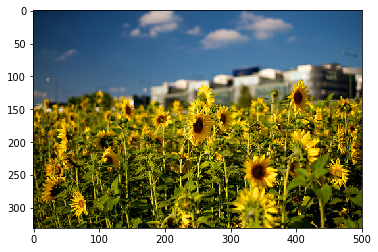

In [6]:
compress_img = retrieve_images('salida/compr_train_00000-of-00003.tfrecord')

compress_img.astype('uint8')
plt.imshow(compress_img)
print('Image shape: {}'.format(compress_img.shape))

## Uncompressed TF_Record

Image height: 331
Image width: 500
Image compress: 0
Image class: 3
Image format: b'jpg'
Image shape: (331, 500, 3)


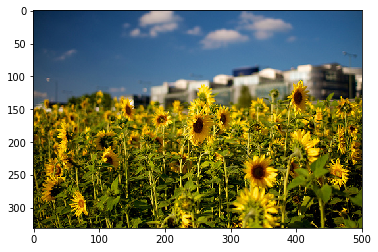

In [7]:
uncompress_img = retrieve_images('salida/no_compr_train_00000-of-00003.tfrecord')

uncompress_img.astype('uint8')
plt.imshow(uncompress_img)
print('Image shape: {}'.format(uncompress_img.shape))

## Original image:

In [8]:
import skimage.io

Image shape: (331, 500, 3)


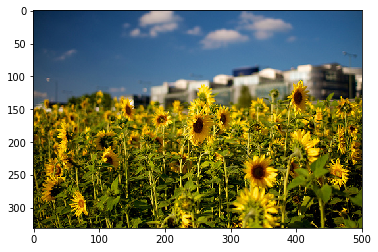

In [9]:
img = skimage.io.imread('/Users/dfreire/Downloads/create_tfrecords/flowers/flower_photos/sunflowers/5999024446_5721493894.jpg')

img.astype('uint8')
plt.imshow(img)
print('Image shape: {}'.format(img.shape))

### Difference compressed TF_Record - Original

Are images equal?: False


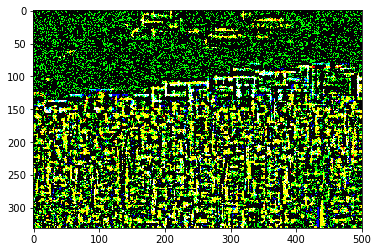

In [10]:
print('Are images equal?: {}'.format(np.array_equal(img,compress_img)))
plt.imshow(img-compress_img)

### Difference uncompressed TF_Record - Original

Are images equal?: True


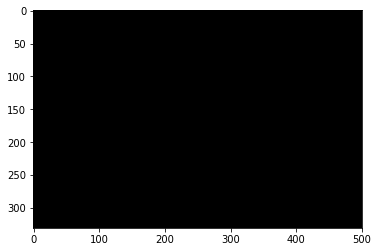

In [11]:
print('Are images equal?: {}'.format(np.array_equal(img,uncompress_img)))
plt.imshow(img-uncompress_img)

## Conclusion:

<br>If the low level pixel values doesn't matter, we can use the compressed TF_Record
<br>Otherwise, use the uncompressed TF_Record

In [70]:
# Interesting to inspect a tf_record:

In [29]:
import tensorflow as tf

for example in tf.python_io.tf_record_iterator('salida/no_compr_train_00000-of-00003.tfrecord'):
    result = tf.train.Example.FromString(example)

In [30]:
result

features {
  feature {
    key: "compression"
    value {
      int64_list {
        value: 1
      }
    }
  }
  feature {
    key: "encoded"
    value {
      bytes_list {
        value: "jpg"
      }
    }
  }
  feature {
    key: "height"
    value {
      int64_list {
        value: 333
      }
    }
  }
  feature {
    key: "image_raw"
    value {
      bytes_list {
        value: "\377\330\377\340\000\020JFIF\000\001\001\001\000H\000H\000\000\377\342\014XICC_PROFILE\000\001\001\000\000\014HLino\002\020\000\000mntrRGB XYZ \007\316\000\002\000\t\000\006\0001\000\000acspMSFT\000\000\000\000IEC sRGB\000\000\000\000\000\000\000\000\000\000\000\000\000\000\366\326\000\001\000\000\000\000\323-HP  \000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\021cprt\000\000\001P\000\000\0003desc\000\000\001\204\000\000\000lwtpt\000\000\001\360\000\000\000\024bkp